# Exercise 1
_by Andrii Holovko_

Task:

* We will work with the diabetes data in `scikit-learn` (via the `load_diabetes`) function.
* Compare three methods for hyperparameter optimization for `RandomForestRegressor` with hyperparameters `max_depth`, `n_estimators`, `max_features`.
    * *Hint*: You should write a function that takes a 3-dimensional array and returns a scalar /1-d arrray.
* To compare the methods, plot the number of iterations against the loss (negative MSE).
* Methods to compare:
    * Random Search (`RandomizedSearchCV`).
    * Grid Search (`GridSearchCV`).
    * Bayesian Optimization using GPy/GPyOpt.
    * Extra: Another black-box method (i.e. cross-entropy method, genetic algorithm, simulated annealing).

In [1]:
import multiprocessing
from os import cpu_count
multiprocessing.set_start_method('forkserver')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

In [2]:
X, y = load_diabetes(return_X_y=True)
rf = RandomForestRegressor(random_state=42)
n_iter = 125

## Hyperparameter selection with GridSearch

In [89]:
# Grid search
param_grid = {
    'max_depth': np.linspace(1, 100, round(n_iter ** (1 / 3))).astype('int'),
    'n_estimators': np.linspace(1, 1000, round(n_iter ** (1 / 3))).astype('int'),
    'max_features': np.linspace(1, 10, round(n_iter ** (1 / 3))).astype('int'),
}
gs = GridSearchCV(
    rf, 
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    cv=4
)
gs.fit(X,y);

Fitting 4 folds for each of 125 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


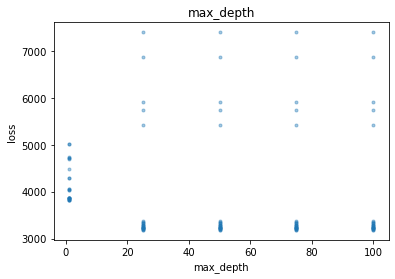

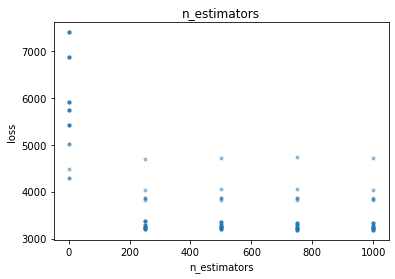

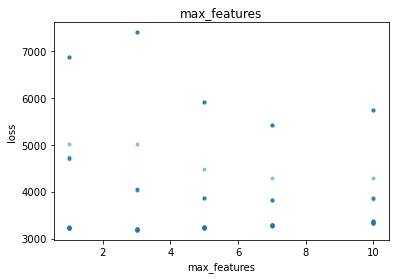

In [90]:
for k, v in param_grid.items():
    plt.title(k)
    plt.plot([params[k] for params in gs.cv_results_['params']], 
             -gs.cv_results_['mean_test_score'], '.', alpha=0.4)
    plt.xlabel(k)
    plt.ylabel('loss')
    plt.show()

## Hyperparameter selection with Random Search

In [91]:
# Random Search
param_dist = {
    'max_depth': randint(1, 100+1),
    'n_estimators': randint(1, 1000+1),
    'max_features': randint(1, 10+1),
}
rs = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    scoring='neg_mean_squared_error', 
    n_iter=n_iter,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    cv=4
)

rs.fit(X,y);

Fitting 4 folds for each of 125 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


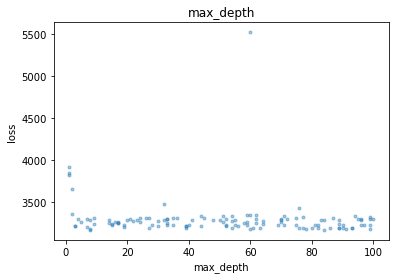

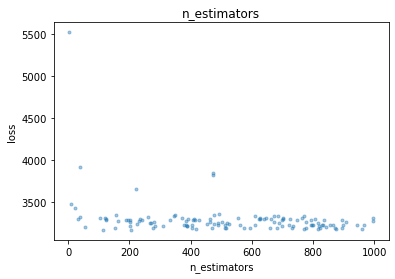

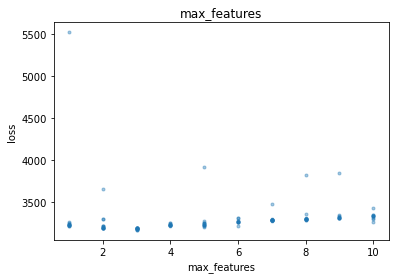

In [92]:
for k, v in param_grid.items():
    plt.title(k)
    plt.plot(np.array([params[k] for params in rs.cv_results_['params']]), 
             -rs.cv_results_['mean_test_score'], '.', alpha=0.4)
    plt.xlabel(k)
    plt.ylabel('loss')
    plt.show()

## Hyperparameter selection with Bayesian Optimization

In [93]:
def L(args):
    max_depth = args[0, 0].astype('int')
    n_estimators = args[0, 1].astype('int')
    max_features = args[0, 2].astype('int')
    
    rf = RandomForestRegressor(
        max_depth=max_depth, 
        n_estimators=n_estimators, 
        max_features=max_features,
        random_state=42,
        n_jobs=1
    )
    rf.fit(X, y)
    score = cross_val_score(rf, X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [94]:
# Bayesian Optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

bds = [
    {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1,100+1)},
    {'name':'n_estimators', 'type':'discrete', 'domain':np.arange(1,1000+1)},
    {'name':'max_features', 'type':'discrete', 'domain':np.arange(1,10+1)}
]

optimizer = BayesianOptimization(
    f=L, 
    model_type='GP', 
    acquisition_type='EI', 
    domain=bds,
    maximize=True,
    verbosity=True,
    num_cores=cpu_count()
)
optimizer.run_optimization(max_iter=n_iter, verbosity=True)

num acquisition: 1, time elapsed: 3.74s
num acquisition: 2, time elapsed: 11.93s
num acquisition: 3, time elapsed: 18.15s
num acquisition: 4, time elapsed: 25.88s
num acquisition: 5, time elapsed: 28.63s
num acquisition: 6, time elapsed: 31.52s
num acquisition: 7, time elapsed: 34.20s
num acquisition: 8, time elapsed: 39.73s
num acquisition: 9, time elapsed: 42.94s
num acquisition: 10, time elapsed: 46.07s
num acquisition: 11, time elapsed: 49.33s
num acquisition: 12, time elapsed: 56.87s
num acquisition: 13, time elapsed: 62.46s
num acquisition: 14, time elapsed: 69.83s
num acquisition: 15, time elapsed: 77.36s
num acquisition: 16, time elapsed: 89.38s
num acquisition: 17, time elapsed: 92.17s
num acquisition: 18, time elapsed: 96.76s
num acquisition: 19, time elapsed: 103.20s
num acquisition: 20, time elapsed: 113.52s
num acquisition: 21, time elapsed: 121.79s
num acquisition: 22, time elapsed: 129.60s
num acquisition: 23, time elapsed: 143.41s
num acquisition: 24, time elapsed: 151.

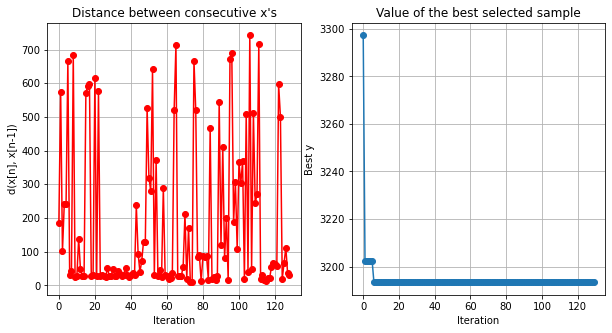

In [95]:
optimizer.plot_convergence()

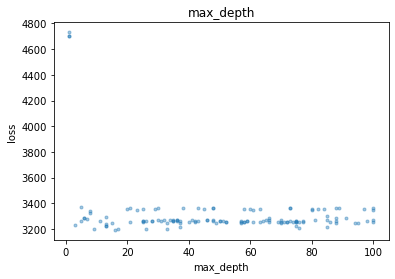

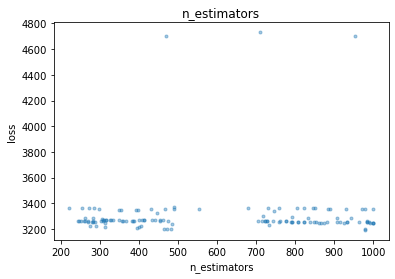

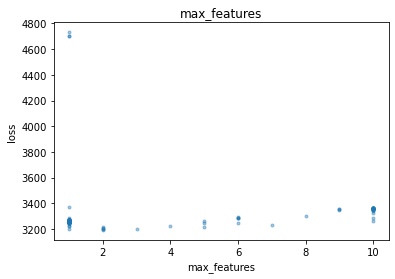

In [96]:
params, loss = optimizer.get_evaluations()
for i, name in enumerate(['max_depth', 'n_estimators', 'max_features']):
    plt.title(name)
    plt.plot(params[:, i], 
             loss, '.', alpha=0.4)
    plt.xlabel(name)
    plt.ylabel('loss')
    plt.show()

## Extra! Hyperparameter selection with Evolutionary Algorithm Search

In [20]:
# !pip install skearn-deap
from evolutionary_search import EvolutionaryAlgorithmSearchCV

In [58]:
param_grid = {
        'max_depth':np.arange(1,100+1),
    'n_estimators':np.arange(1,1000+1),
    'max_features':np.arange(1,10+1)}


In [81]:
eas = EvolutionaryAlgorithmSearchCV(
    rf,
    params=param_grid,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    population_size=25,
    gene_mutation_prob=0.10,
    gene_crossover_prob=0.5,
    tournament_size=3,
    generations_number=5,
    n_jobs=1,
)

eas.fit(X, y)

/home/andrii/miniconda3/envs/ve002/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/andrii/miniconda3/envs/ve002/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Types [1, 1, 1] and maxint [99, 999, 9] detected
--- Evolve in 1000000 possible combinations ---
gen	nevals	avg     	min    	max     	std    
0  	25    	-3260.74	-3362.5	-3185.81	45.8295
1  	16    	-3221.51	-3321.23	-3185.81	29.5868
2  	18    	-3262.89	-4706.87	-3179.35	295.211
3  	7     	-3190.74	-3220.38	-3179.35	11.2202
4  	16    	-3182.56	-3190.57	-3179.35	3.59627
5  	13    	-3180.17	-3185.81	-3179.35	1.90305
Best individual is: {'max_depth': 69, 'n_estimators': 70, 'max_features': 3}
with fitness: -3179.347189491181


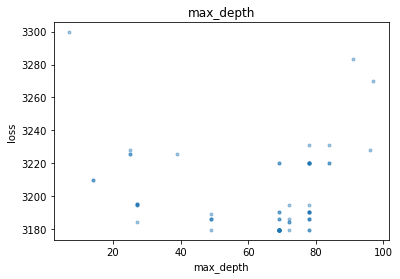

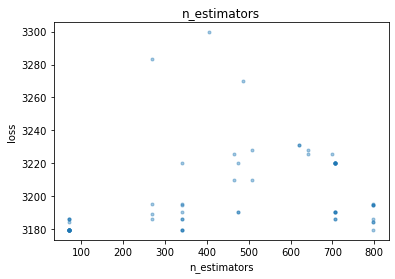

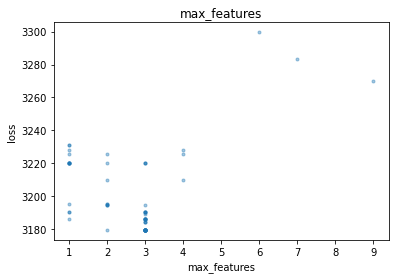

In [84]:
for k, v in param_grid.items():
    plt.title(k)
    plt.plot(np.array([params[k] for params in eas.cv_results_['params']]), 
             -np.array(eas.cv_results_['mean_test_score']), '.', alpha=0.4)
    plt.xlabel(k)
    plt.ylabel('loss')
    plt.show()

## Summary

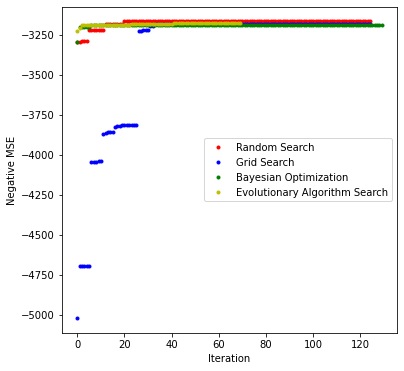

In [98]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(gs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
y_eas = np.maximum.accumulate(eas.cv_results_['mean_test_score'])

plt.figure(figsize=(6,6))
plt.plot(y_rs, 'r.', label='Random Search')
plt.plot(y_gs, 'b.', label='Grid Search')
plt.plot(y_bo, 'g.', label='Bayesian Optimization')
plt.plot(y_eas, 'y.', label='Evolutionary Algorithm Search')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='right');

Let's look closer:

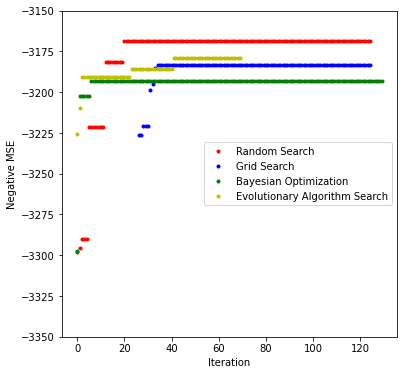

In [101]:
plt.figure(figsize=(6,6))
plt.plot(y_rs, 'r.', label='Random Search')
plt.plot(y_gs, 'b.', label='Grid Search')
plt.plot(y_bo, 'g.', label='Bayesian Optimization')
plt.plot(y_eas, 'y.', label='Evolutionary Algorithm Search')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.ylim((-3350, -3150))
plt.legend(loc='right');

We see, that `Random Search` is the leader. `Bayesian Optimization` is the worst. `Evolutionary Algorithm Search` managed with outperforming `Grid Search`.

Running time of the algorithms:
- `Random Search`: 1m 42s (125 evaluations of CV score)
- `Grid Search`: 1m 49s (125 evaluation)
- `Bayesian Optimization`: 14m 48s (125 evaluation)
- `Evolutionary Algorithm Search`: 2m 59s (70 evaluation)

On the other hand, `Bayesian Optimization` and `Evolutionary Algorithm Search` were noticably better then their  competitors for the first 12 evaluations. This means these two approaches are better for cases, when function estimation is expensive. 